# Imports

In [351]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import re
import nltk


warnings.filterwarnings("ignore")

In [352]:
complaints = pd.read_excel('EaUgXb.xlsx')

In [353]:
# check for any missing values
print("Missing values in test dataset:")
print(complaints.isnull().sum())
print(complaints[complaints.isnull().any(axis=1)])


Missing values in test dataset:
customerID          0
complaint           0
complaint_number    0
dtype: int64
Empty DataFrame
Columns: [customerID, complaint, complaint_number]
Index: []


In [354]:
#check unique values in each column
print("Unique values in each column:")
for col in complaints.columns:
    print(f"{col}: {complaints[col].nunique()} unique values")

Unique values in each column:
customerID: 704 unique values
complaint: 1605 unique values
complaint_number: 5 unique values


So only 704 customers over the 7043 registered in the other dataset have given feedbacks. Moreover we know that some among the 704 customers have left more than one complaint, in fact, up to five!

---

### SENTIMENT ANALYSIS

This sentiment analysis wants to focus on the negativity because we know the dataset is made only of complaints (negative feedbacks) of customers, so, for sure, all of them are negative; but at what intensity? \
Our aim is to classify the complaints in three levels of intensity (mild, moderate, severe)

**STRATEGY**
1. Implementing a pretrained model (VADER) 
    We can use it to have a quick baseline model working for unlabeled data.
2. Labeling or Defining the Sentiment
    If possible, manually label a small sample (~100 complaints) for a custom supervised model (better but more work)
3. Modeling
    Train a classifier (Logistic Regression, Random Forest, fine-tune a Transformer like BERT, etc.)

### Using VADER (pretrained, unlabeled)

Since Vader is composed by four key scores (pos, neg, neu, compound) in its sentiment analysis, and we are interested only in classifying the negative intensity of the complaints, we modify it to make it suitable for our objective.

We want to classify the degree of negativity by thresholding a certain score that we calculate for each complaint. This score is the sum of other partial scores that are obtained by looking at the words (adjectives, ungency terms, intensifiers) inside the complaint. 

To personalize the model we look at the most recurrent adverbs and adjectives, then we decide which will indicate more moderate or severe expressions.

In [355]:

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Function to extract adjectives and adverbs
def extract_adj_adv_spacy(text):
    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Extract adjectives and adverbs based on their POS tags
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    adverbs = [token.text for token in doc if token.pos_ == "ADV"]
    
    return adjectives, adverbs



In [356]:
# Process complaints
all_adjectives = []
all_adverbs = []
# To handle large datasets efficiently, process in batches
for complaint in complaints['complaint']:
    adj, adv = extract_adj_adv_spacy(complaint)
    all_adjectives.extend(adj)
    all_adverbs.extend(adv)

# Count frequencies
adj_freq = Counter(all_adjectives)
adv_freq = Counter(all_adverbs)




In [357]:
top_adjectives = adj_freq.most_common(20)
print("Top 20 Adjectives:")
for adj, count in top_adjectives:
    print(f"{adj}: {count}")


Top 20 Adjectives:
monthly: 332
high: 319
frustrating: 267
slow: 195
frequent: 169
online: 159
difficult: 147
poor: 139
unreliable: 132
impossible: 131
long: 123
unacceptable: 116
better: 102
multiple: 97
unhelpful: 95
inconsistent: 91
loyal: 88
basic: 78
ongoing: 64
available: 58


In [358]:
top_adverbs = adv_freq.most_common(20)
print("\nTop 20 Adverbs:")
for adv, count in top_adverbs:
    print(f"{adv}: {count}")


Top 20 Adverbs:
especially: 189
extremely: 171
frequently: 159
very: 142
even: 110
too: 98
often: 95
consistently: 90
constantly: 55
immediately: 48
still: 46
altogether: 43
effectively: 37
recently: 36
online: 34
properly: 32
much: 31
lately: 30
more: 30
long: 29


Now we define a function where the score is calculated based which specific negative words appear in a complaint, then we weight the score also with the vader scores (neg and compound) and finally there is the thresholding used for the classification of intensity level of the single complaint.

In [359]:
def vader_classifier(text):
    # Get VADER scores
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    
    # Extract scores
    neg_score = scores['neg']
    compound = scores['compound']
    
    severity_score = 0
    
    # Defining severe negative words
    severe_words = ["terrible", "worst", "horrible", "awful", "outrageous", 
                   "unacceptable", "disgusting", "appalling", "furious", 
                   "ridiculous", "scam", "fraud", "lawsuit", "legal action", 
                   "frustrating", "frustrat" "dissatisfied", "unreliable", 
                   "cancel", "frustrated", "loyal", "loyalty",  "no loyalty",
                   "long-term", "impossible"]

    
    # Defining moderate negative words
    moderate_words = ["disappointed", "disappointing", "annoying", "problem", 
                     "issue", "issues" "poor", "unhappy", "bad", "seem", "inconvenient", 
                     "expect", "delay", "wait", "slow", "difficult", "confusing", 
                     "unresolved", "unhelpful", "expected", "unresponsive", "slower", 
                     "slow", "inconsistent", "poor"]

    # Defining intensifiers
    intensifiers = ["very", "extremely", "absolutely", "completely", "totally", "excessively", "excessive", "high", "especially", "properly"]

    
    # Defining urgency indicators
    urgency_words = ["immediately", "urgent", "asap", "right away", "emergency"]

    
    for word in text.lower().split():
        if word in severe_words:
            severity_score += 3
        if word in moderate_words:
            severity_score += 2
        if word in intensifiers:
            severity_score += 1
        if word in urgency_words:
            severity_score += 2

    
    # Weight with VADER scores
    severity_score += (neg_score * 5)  # Multiply negative score for more weight
    severity_score -= (compound * 3)   # Subtract compound (since negative compound is negative)

    # Tresholding classification
    if severity_score > 4:
        return 'severe'
    elif severity_score > 1:
        return 'moderate'
    else:
        return 'mild'
    

In [360]:
complaints['severity'] = complaints['complaint'].apply(vader_classifier)


Then we check and we visualize the distribution of the negativity classes

In [361]:

# Check the distribution
severity_distribution = complaints['severity'].value_counts()
print(severity_distribution)


severity
severe      818
moderate    516
mild        271
Name: count, dtype: int64


Text(0, 0.5, 'Count')

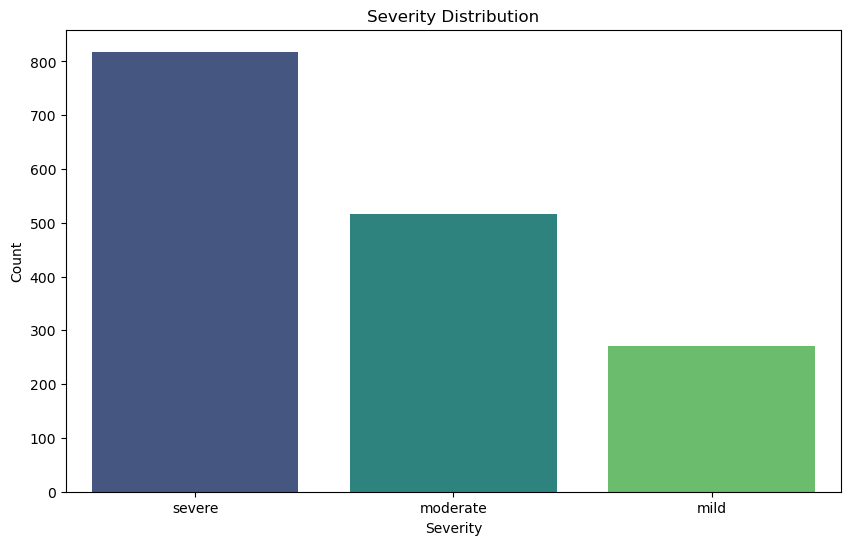

In [362]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.countplot(data=complaints, x='severity', palette='viridis')
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')

Finally, we visualize more insightful data regarding the order number of the complaints; in particular, we check how the intensity modifies depending on whether it is the first, the second, etc., complaint published.

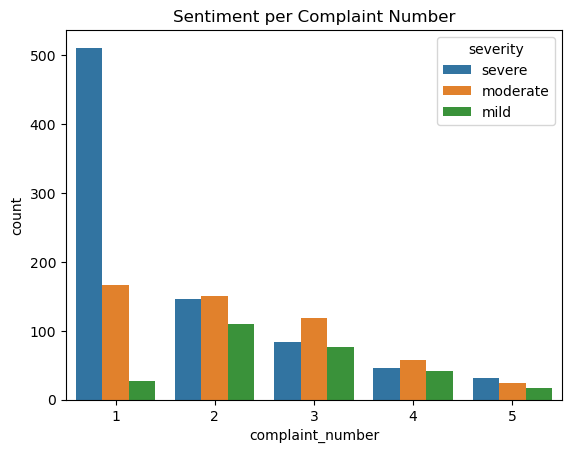

In [363]:
# Plot sentiment trend over complaint numbers
sns.countplot(x='complaint_number', hue='severity', data=complaints)
plt.title('Sentiment per Complaint Number')
plt.show()

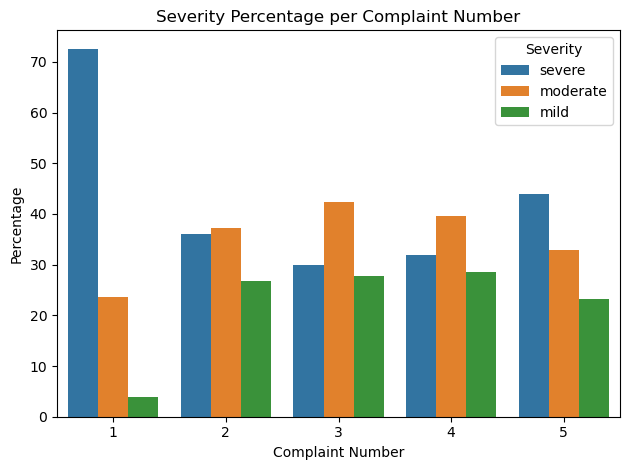

In [339]:
# For each complaint number, calculate the percentage of each severity
severity_percentage = complaints.groupby('complaint_number')['severity'].value_counts(normalize=True) * 100

# Reset index for better visualization
severity_percentage = severity_percentage.reset_index(name='percentage')
# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='severity', data=severity_percentage)
plt.title('Severity Percentage per Complaint Number')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

**COMMENTA RISULTATI**

guarda come va prendendo solo quelli che churnano

---

## Trained model on small labeled sample

In [364]:
# Take a sample of 110 elements from the dataset
sample_size = 110
complaints = complaints.drop(columns=['severity'])
sampled_complaints = complaints.sample(n=sample_size, random_state=42)
# Save the sampled dataset to an csv file
sampled_complaints.to_csv('sampled_complaints.csv', index=False)


In [373]:
complaints2 = pd.read_csv('labeled_complaints.csv', sep=";")
complaints2

,complaint,severity_label
0,I have been charged a high monthly fee of $79....,moderate
1,The internet speed has been inconsistent latel...,severe
2,When I tried to contact customer support about...,severe
3,Despite having tech support included in my pla...,severe
4,I was charged the full amount this month even ...,moderate
...,...,...
104,The DSL internet speed is much slower than exp...,moderate
105,I’m frustrated with the lack of flexibility or...,severe
106,"My streaming services, both TV and movies, fre...",severe
107,"The monthly charges are extremely high, and I ...",severe


In [374]:
# Split data into training and testing sets

X = complaints2['complaint']
y = complaints2['severity_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [376]:

# Create and train a model pipeline
class_weights = {'mild': 5, 'moderate': 2, 'severe': 1}  # Higher weight for underrepresented classes

# This pipeline will vectorize the text and apply a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight={'mild': 5, 'moderate': 2,
                                                      'severe': 1},
                                        random_state=42))])

In [378]:
# Evaluate the model
predictions = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, predictions))



Classification Report:
              precision    recall  f1-score   support

        mild       0.00      0.00      0.00         2
    moderate       0.50      0.14      0.22         7
      severe       0.65      1.00      0.79        13

    accuracy                           0.64        22
   macro avg       0.38      0.38      0.34        22
weighted avg       0.54      0.64      0.54        22



In [379]:
# Apply the model to all complaints
complaints2['predicted_severity'] = pipeline.predict(complaints2['complaint'])


In [389]:
# use the model on the complete dataset
complaints3 = pd.read_excel('EaUgXb.xlsx')
complaints3['predicted_severity'] = pipeline.predict(complaints3['complaint'])


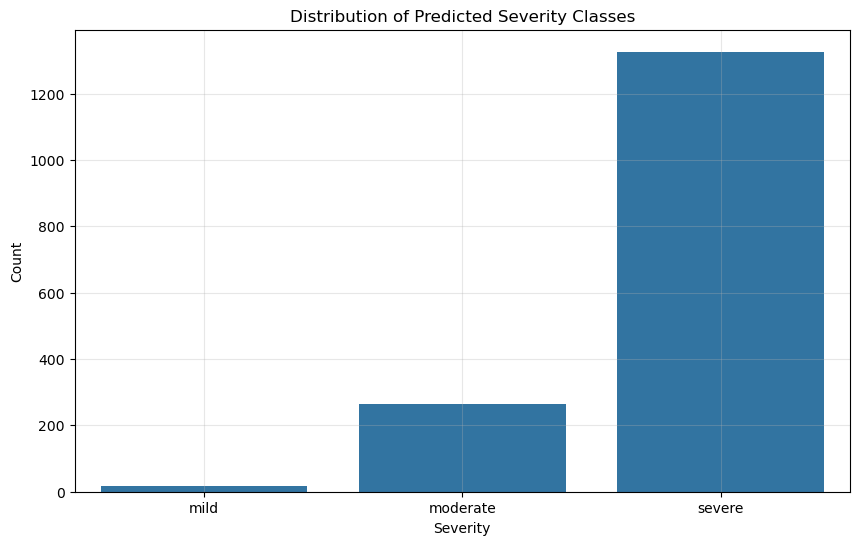

In [390]:
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_severity', data=complaints3, order=['mild', 'moderate', 'severe'])
plt.title('Distribution of Predicted Severity Classes')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()


In [391]:
# Check the distribution
severity_distribution3 = complaints3['predicted_severity'].value_counts()
print(severity_distribution3)

predicted_severity
severe      1326
moderate     263
mild          16
Name: count, dtype: int64


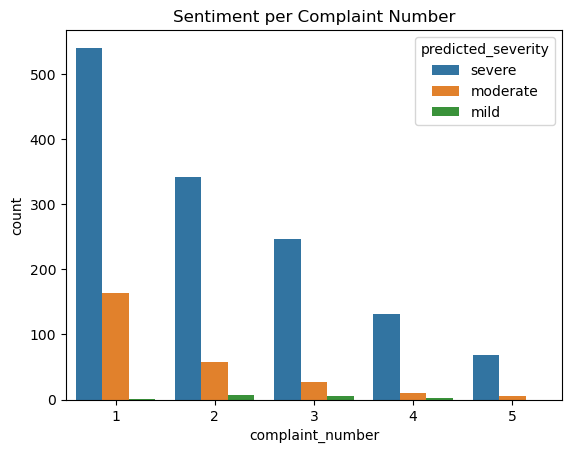

In [392]:
sns.countplot(x='complaint_number', hue='predicted_severity', data=complaints3)
plt.title('Sentiment per Complaint Number')
plt.show()

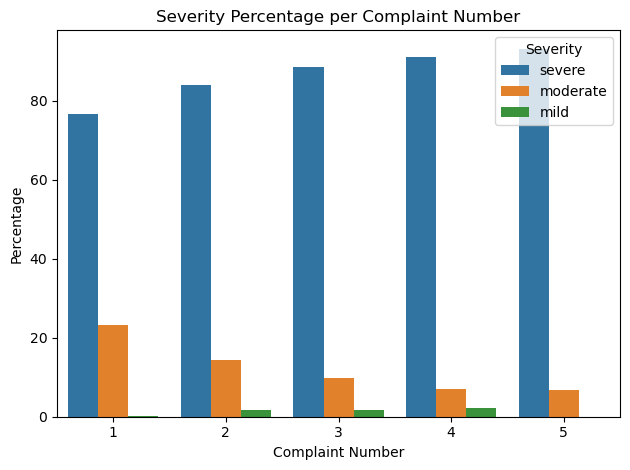

In [393]:
# For each complaint number, calculate the percentage of each severity
severity_percentage = complaints3.groupby('complaint_number')['predicted_severity'].value_counts(normalize=True) * 100

# Reset index for better visualization
severity_percentage = severity_percentage.reset_index(name='percentage')
# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='predicted_severity', data=severity_percentage)
plt.title('Severity Percentage per Complaint Number')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()